In [33]:
import os
import shutil
import random
import numpy as np


base_dir = 'CNN'

categories = ['Enfermo', 'Exhausto', 'Sano']


for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)


train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15


for category in categories:
    category_dir = os.path.join(base_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)
    
    train_split = int(train_ratio * len(images))
    validation_split = int(validation_ratio * len(images))
    
    train_images = images[:train_split]
    validation_images = images[train_split:train_split + validation_split]
    test_images = images[train_split + validation_split:]
    
    for image in train_images:
        shutil.move(os.path.join(category_dir, image), os.path.join(base_dir, 'train', category, image))
    for image in validation_images:
        shutil.move(os.path.join(category_dir, image), os.path.join(base_dir, 'validation', category, image))
    for image in test_images:
        shutil.move(os.path.join(category_dir, image), os.path.join(base_dir, 'test', category, image))

print("Data has been successfully reorganized.")


Data has been successfully reorganized.


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


batch_size = 32
epochs = 20
input_shape = (150, 150, 3)  


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 clases de salida: sano, exhausto, enfermo
])


model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)


Found 32 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Found 10 images belonging to 3 classes.
Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4375 - loss: 1.0866 - val_accuracy: 0.5000 - val_loss: 1.0128
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0128
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step - accuracy: 0.5000 - loss: 1.0332 - val_accuracy: 0.5000 - val_loss: 0.9976
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9976
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step - accuracy: 0.5000 - loss: 0.9919 - val_accuracy: 0.5000 - val_loss: 0.9860
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.9860
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step - accuracy: 0.5000 - loss: 0.9745 - val_accuracy: 0.5000 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5000 - loss: 0.8387
Test accuracy: 0.5


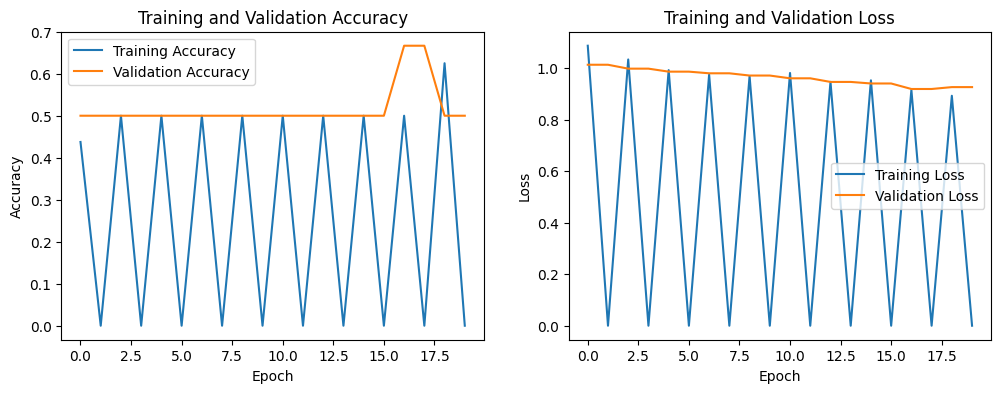

In [35]:
import matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
El estado del paciente es: Enfermo
Probabilidad: 0.4530494809150696


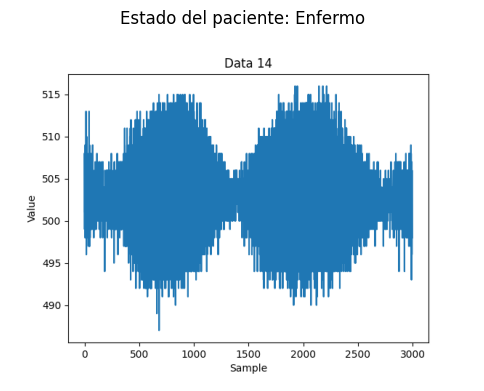

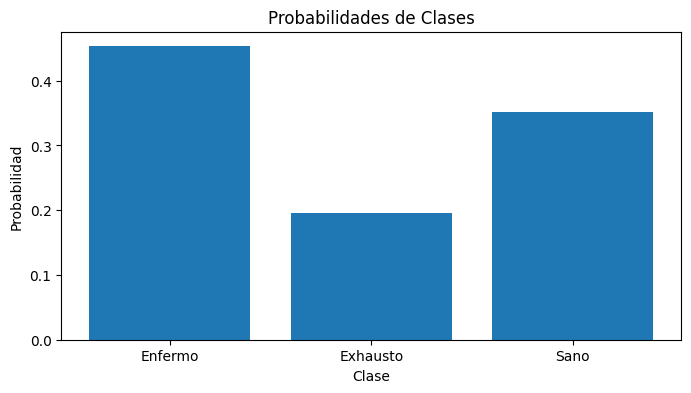

In [41]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def predecir_estado(imagen_path):
    img = Image.open(imagen_path)
    img = img.convert('RGB')  
    img = img.resize((150, 150))  

    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Realizar la predicción
    prediccion = model.predict(img_array)
    clase_idx = np.argmax(prediccion[0])
    probabilidad = prediccion[0][clase_idx]  # Obtener la probabilidad de la clase predicha

    clases = ['Enfermo', 'Exhausto', 'Sano']
    estado = clases[clase_idx]

    return estado, probabilidad, prediccion[0]

# Predicción del estado del paciente
imagen_path = 'img_bien/data_12.png'
estado_paciente, probabilidad, predicciones = predecir_estado(imagen_path)
print(f'El estado del paciente es: {estado_paciente}')
print(f'Probabilidad: {probabilidad}')

# Visualización de la imagen y las predicciones
img = Image.open(imagen_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f'Estado del paciente: {estado_paciente}')
plt.axis('off')
plt.show()

# Visualización de las probabilidades de todas las clases
plt.figure(figsize=(8, 4))
plt.bar(range(len(predicciones)), predicciones, tick_label=['Enfermo', 'Exhausto', 'Sano'])
plt.title('Probabilidades de Clases')
plt.xlabel('Clase')
plt.ylabel('Probabilidad')
plt.show()
